# Imports

In [1]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import spacy

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from tqdm._tqdm_notebook import tqdm_notebook
from importlib import reload
from tqdm import tqdm

nlp = spacy.load('en_core_web_sm')

%matplotlib inline

In [2]:
tqdm_notebook.pandas()

In [3]:
import functions as fun

Using TensorFlow backend.


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
# def POS_reverse_lookup(x, POS):
#     code = POS_lookup[POS]
#     try:
#         return x[code]
#     except:
#         pass

In [6]:
# def POS_reverse_lookup_n_ratio(x, code):
#     try:
#         return x.POS_counts[code] / x.word_count
#     except:
#         return 0

In [7]:
# def TAG_reverse_lookup_n_ratio(x, code):
#     try:
#         return x.TAG_counts[code] / x.word_count
#     except:
#         return 0

Temporarily leaving this function here until I've re-imported from the functions doc and I know it's working.

In [8]:
# def feature_graphics(df, col_start, col_end, add_columns=None, scatterdim=(1600,1600), 
#                        figsize=(20,20), browser=False):
#     """Creates scatter matrix, histograms, and corrolation matrix for 
#     supplied dataframe and columns.
    
#     Parameters:
        
#         df: DataFrame
#             DataFrame of movie information, probably from either rotten_df_cut
#             or screenplays_cut.
            
#         col_start: string
#             Name of column in sequence to start with.
            
#         col_end: string
#             Name of column in sequence to end with.
            
#         scatterdim: tuple
#             dimensions in pixels for scatter matrix
            
#         figsize: tuple
#             dimensions in inches for histograms and hamburgers.
            
#         browser: bool
#             Indicates whether scatter matrix also opens in browser."""

#     # Create subset DataFrame using start & end columns.
#     temp = df[df.columns[\
#         list(df.columns).index(col_start):list(df.columns)\
#                                                .index(col_end)+1]].copy()
    
#     # If the DataFrame is rotten_df_cut, we should add the RottenScores column.
#     try:
#         temp['RottenScore'] = df.RottenScores
#         color = rotten_df_cut.RottenScores/100
#     except:
#         pass
    
#     # Moving data to format Plotly will understand for scatter matrix.
#     dimensions = []
#     for column in temp.columns:
#         dimensions.append({'label':column,'values':temp[column]})

#     # Creating scatter matrix.
#     data = [go.Splom(
#         dimensions=dimensions,
#         marker={'size':2,
#                 'color':color,
#                 'colorbar':{'thickness':20}
#                }
#     )]
#     layout = go.Layout(height=scatterdim[1],
#                        width=scatterdim[0])
#     fig = go.Figure(data, layout)
#     fig.show();   
    
#     # Plotly can send the graph to a browser; useful for dashboards.
#     if browser == True:
#         pyo.plot(fig);
    
#     # Create histogram of the same data.
#     temp.hist(figsize=figsize);
    
#     # Create corrolation heatmap of the same data.
#     plt.subplots(figsize=figsize)
#     sns.heatmap(temp.corr(), annot = True);

# Exploratory Data Analysis

## Local Functions

In [9]:
# Counting punctuation and parts of speech
def count_punct(text, punk):
    return text.count(punk) / len(text.split())

def count_pos(x):
    return x.count_by(spacy.attrs.POS)

def count_tag(x):
    return x.count_by(spacy.attrs.TAG)

# Determining the average sentence length for a given script.
def sent_len(str):
    doc = nlp(str)
    count = 0
    
    for sent in doc.sents:
        count += 1
    
    return len(str.split()) / count

# These two find the acutal POS name for the code number supplied, for
# creating the column names.
def POS_reverse_lookup_n_ratio(x, code):
    try:
        return x.POS_counts[code] / x.word_count
    except:
        pass

def TAG_reverse_lookup_n_ratio(x, code):
    try:
        return x.TAG_counts[code] / x.word_count
    except:
        return 0

## Bringing in the data

Reading back in data we scubbed in 'scrubbing'. 

In [10]:
screenplays = pd.read_csv('screenplays_scrub.csv', index_col=0)
rotten_df = pd.read_csv('rotten_df_scrub.csv', index_col=0)

screenplays.dropna(inplace=True)

In [11]:
# Adding column showing if a title is above or below a score of 50.
rotten_df['good_or_bad'] = rotten_df.rotten_scores.apply(
    lambda x: 1 if x >=50 else 0)

# Re-ordering columns to line up the two data sources for later use.
screen_cols = list(screenplays.columns)
screen_cols.remove('good_or_bad')
screen_cols.append('good_or_bad')
screenplays = screenplays[screen_cols].copy()

rotten_cols = list(rotten_df.columns)
rotten_cols.remove('rotten_scores')
rotten_cols.append('rotten_scores')
rotten_df = rotten_df[rotten_cols].copy()
rotten_df.drop('titles', axis=1, inplace=True)

In [12]:
# sort_cols = list(rotten_df.columns[:38])
# sort_cols.extend(sorted(list(rotten_df.columns[38:-2])))
# sort_cols.extend(list(rotten_df.columns[-2:]))

In [13]:
# rotten_df = rotten_df[sort_cols]
rotten_df.rename(columns={'titles_formatted':'titles'}, inplace=True)

## Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [14]:
combined_df = pd.concat([rotten_df[['titles', 'just_words']],
                         screenplays[['titles', 'just_words']]],
                         ignore_index=True)

combined_df.drop_duplicates(subset='titles', inplace=True)

In [15]:
cv = CountVectorizer(min_df=.1, max_df=.6)
victor = cv.fit_transform(combined_df.just_words)
LDA = LatentDirichletAllocation(n_components=10, random_state=42)
combined_df['category'] = LDA.fit_transform(victor).argmax(axis=1)

Showing the category word groupings, then creating materiels to be used later.

In [16]:
# This will house the dictionaries for using in the dashboard.
cat_word_dicts = []

# Priting out the word gropuings and filling in the cat_word_dicts list.
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
    print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')
    cat_word_dicts.append({index:[cv.get_feature_names()[i]\
                                  for i in topic.argsort()[-15:]]})
#     cat_word_dicts.append([cv.get_feature_names()[i]\
#                           for i in topic.argsort()[-15:]])

cat_word_df = pd.DataFrame()

# Creating a dataframe for export to .csv for later use.
for i in range(len(cat_word_dicts)):
    cat_word_df[i] = cat_word_dicts[i][i]

# Creating category mapping for all dataframes to indicate how I see 
# The groupings. This part is just based on my looking them over.
category_map = {0: 'Dark & Political', 1: 'Sports, Comedy, Silly Horror', 
                2: 'Conflict', 3: 'Holiday, Films I Haven\'t Seen',
                4: 'Light-Hearted', 5: 'Unusual Language or Slang', 
                6: 'Violence & Gangster', 7: 'Romance & Light Drama', 
                8: 'Life Stories', 9: 'Straight Up Horror'}
combined_df['category_label'] = combined_df.category.map(category_map)

THE TOP 15 WORDS FOR CATEGORY #0
['government', 'fight', 'human', 'war', 'law', 'body', 'children', 'power', 'court', 'country', 'state', 'president', 'death', 'police', 'dr']


THE TOP 15 WORDS FOR CATEGORY #1
['buddy', 'wow', 'team', 'cool', 'uh', 'ball', 'aint', 'ya', 'ah', 'em', 'dog', 'ha', 'game', 'whoa', 'ok']


THE TOP 15 WORDS FOR CATEGORY #2
['air', 'safe', 'jim', 'ship', 'war', 'jack', 'officer', 'clear', 'shot', 'shoot', 'fire', 'police', 'john', 'captain', 'gun']


THE TOP 15 WORDS FOR CATEGORY #3
['ooh', 'whoa', 'ah', 'christmas', 'cool', 'wow', 'bye', 'daddy', 'charlie', 'sam', 'honey', 'jack', 'um', 'uh', 'mom']


THE TOP 15 WORDS FOR CATEGORY #4
['uh', 'grunts', 'radio', 'crowd', 'chatter', 'cheering', 'speaking', 'indistinct', 'continues', 'laughs', 'playing', 'laughing', 'sighs', 'chuckles', 'music']


THE TOP 15 WORDS FOR CATEGORY #5
['aint', 'poor', 'sister', 'darling', 'war', 'brother', 'child', 'death', 'lady', 'children', 'king', 'lord', 'dear', 'shall', 'mrs']


I'm going to need the combined dataframes with LDA categories for the dashboard later on.

In [17]:
screenplays = pd.merge(screenplays, combined_df[['titles','category', 'category_label']],
                how='left', on='titles')

rotten_df = pd.merge(rotten_df, combined_df[['titles','category', 'category_label']],
                how='left', on='titles')

cat_word_df.to_csv('cat_word_df.csv', header=True)

combined_df.to_csv('combined_df.csv')

## Metacritic

### Feature Engineering

Will be creating quite a few new columns filled with script attributes such as word counts, sentiment, and parts of speech.

In [18]:
# rotten_df.dropna(inplace=True)
# screenplays.dropna(inplace=True)

In [19]:
# screenplays['temp'] = screenplays['no_stop'].apply(lambda x: type(x))

Putting in some counts.

In [20]:
screenplays['word_count'] = screenplays.all_together_now.apply(
    lambda x: len(x.split()))
screenplays['unique_words'] = screenplays.no_stop.apply(
    lambda x: len(x.split()))

Creating columns for sentiment scoring: positive, negative, neutral, and compound.

In [21]:
sid = SentimentIntensityAnalyzer()

screenplays['sentiment_scores'] = screenplays.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

screenplays['sentiment_negative'] = screenplays.sentiment_scores.apply(
    lambda x: x['neg'])
screenplays['sentiment_neutral'] = screenplays.sentiment_scores.apply(
    lambda x: x['neu'])
screenplays['sentiment_positive'] = screenplays.sentiment_scores.apply(
    lambda x: x['pos'])
screenplays['sentiment_compound'] = screenplays.sentiment_scores.apply(
    lambda x: x['compound'])

Removing anything with fewer words words so that short scripts don't throw off the modeling.

In [22]:
screenplays_cut = screenplays.copy().drop(
    index=(screenplays[screenplays['word_count'] < 1000].index), axis=0)

More columns for punctuation ratios.

In [23]:
screenplays_cut['colon_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
screenplays_cut['semi_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
screenplays_cut['comma_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
screenplays_cut['ellipsis_ratios'] = screenplays_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

And sentence length.

In [24]:
screenplays_cut['sentence_length'] = screenplays_cut.no_stop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [25]:
# cv = CountVectorizer(min_df=.1, max_df=.6)
# victor = cv.fit_transform(screenplays_cut.just_words)
# LDA = LatentDirichletAllocation(n_components=10, random_state=42)
# screenplays_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [26]:
# for index,topic in enumerate(LDA.components_):
#     print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
#     print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
#     print('\n')

In [27]:
# category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
#                 2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
#                 4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
#                 7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
#                 9: 'Wrondoing & Death'}
# screenplays_cut['category_label'] = screenplays_cut.category.map(category_map)

### Parts of Speech

Breaking out both coarse and fine grained approaches to parts of speech, to create a ratio of how many of each is used in each screenplay.

In [28]:
screenplays_cut['nlp'] = screenplays_cut.all_together_now.progress_apply(nlp)
screenplays_cut.to_csv('screenplays_cut.csv')

In [29]:
# Applying the 'progress_apply' function to each row to get the actual words.
screenplays_cut['POS_counts'] = screenplays_cut.nlp.progress_apply(count_pos)
screenplays_cut['TAG_counts'] = screenplays_cut.nlp.progress_apply(count_tag)

# POS_codes and TAG codes will be used to identify unique codes 
# used throughout vocabulary.
POS_codes = set()

for i, item in enumerate(screenplays_cut.POS_counts):
    POS_codes.update(item.keys())

TAG_codes = set()

for i, item in enumerate(screenplays_cut.TAG_counts):
    TAG_codes.update(item.keys())

In [30]:
# Not sure if this is still necessary or not.

# for code in POS_codes:
#     screenplays_cut[screenplays_cut.nlp[50].vocab[code].text] = None

In [31]:
all_scripts = set()

for i, script in enumerate(screenplays_cut.just_words):
    all_scripts.update(script.split())

all_scripts = [script for script in all_scripts]

all_scripts = ' '.join(all_scripts)

all_scripts = nlp(all_scripts[:30])

In [32]:
# TAG_reverse_lookup = {}
# for code in TAG_codes:
#     key = all_scripts.vocab[code].text
#     value = code
#     TAG_reverse_lookup[key] = value

In [33]:
# POS_lookup = {}
# for code in POS_codes:
#     key = code
#     value = all_scripts.vocab[code].text
#     POS_lookup[key] = value

In [34]:
# POS_reverse_lookup = {}
# for code in POS_codes:
#     key = all_scripts.vocab[code].text
#     value = code
#     POS_reverse_lookup[key] = value

In [35]:
# for code, abb in POS_lookup.items():
#     try:
#         screenplays_cut[abb] = screenplays_cut.apply(
#             lambda x: x.POS_counts[code] / x.word_count, axis=1)
#     except:
#         pass

In [36]:
# for code, abb in TAG_lookup.items():
#     try:
#         screenplays_cut[abb] = screenplays_cut.apply(
#             lambda x: x.TAG_counts[code] / x.word_count, axis=1)
#     except:
#         pass

Adding POS columns.

In [37]:
# TAG_lookup will be used for adding POS word to column name.
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

# POS_lookup will be used for adding POS word to column name.
# POS_lookup = {}
# for k, v in screenplays_cut.POS_counts[50].items():
#     POS_lookup[screenplays_cut.nlp[50].vocab[k].text] = k

POS_lookup = {}
for code in POS_codes:
    key = code
    value = all_scripts.vocab[code].text
    POS_lookup[key] = value

# Adding POS column and adding POS name as column name.
for code, abb in POS_lookup.items():
    screenplays_cut[abb] = screenplays_cut.apply(
        POS_reverse_lookup_n_ratio, args=[code], axis=1)

# Adding TAG column and adding TAG name as column name.
for code, abb in TAG_lookup.items():
    screenplays_cut[abb] = screenplays_cut.apply(
        TAG_reverse_lookup_n_ratio, args=[code], axis=1)

In [38]:
# for POS in screenplays_cut.columns[24:41]:
#     screenplays_cut[POS] = screenplays_cut.apply(
#         POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [39]:
screenplays_cut = screenplays_cut.fillna(0)

screenplays_cut.to_csv('screenplays_cut.csv')

## Rottentomatoes

### Feature Engineering

As with metacritic, will be creating quite a few new columns filled with script attributes such as word counts, sentiment, and parts of speech.

Putting in some counts.

In [40]:
rotten_df['word_count'] = rotten_df.all_together_now.apply(
    lambda x: len(x.split()))
rotten_df['unique_words'] = rotten_df.no_stop.apply(
    lambda x: len(x.split()))

In [41]:
rotten_df_cut = rotten_df.copy().drop(
    index=(rotten_df[rotten_df['word_count'] < 1000].index), axis=0)

Creating columns for sentiment scoring: positive, negative, neutral, and compound.

In [42]:
sid = SentimentIntensityAnalyzer()

rotten_df_cut['sentiment_scores'] = rotten_df.no_stop.progress_apply(
    lambda x: sid.polarity_scores(x))

rotten_df_cut['sentiment_negative'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neg'])
rotten_df_cut['sentiment_neutral'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['neu'])
rotten_df_cut['sentiment_positive'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['pos'])
rotten_df_cut['sentiment_compound'] = rotten_df_cut.sentiment_scores.apply(
    lambda x: x['compound'])

Removing anything with fewer words words so that short scripts don't throw off the modeling.

More columns for punctuation ratios.

In [43]:
rotten_df_cut['colon_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ':'))
rotten_df_cut['semi_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ';'))
rotten_df_cut['comma_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, ','))
rotten_df_cut['ellipsis_ratios'] = rotten_df_cut.no_stop.apply(
    lambda x: count_punct(x, '...'))

And sentence length.

In [44]:
rotten_df_cut['sentence_length'] = rotten_df_cut.no_stop.progress_apply(
    sent_len)

### Latent Derichlet Allocation

Finding the categories inherent in the screenplays by analyzing the words and grouping the screenplays.

In [45]:
# cv = CountVectorizer(min_df=.1, max_df=.6)
# victor = cv.fit_transform(rotten_df_cut.JustWords)
# LDA = LatentDirichletAllocation(n_components=10, random_state=42)
# rotten_df_cut['category'] = LDA.fit_transform(victor).argmax(axis=1)

In [46]:
# for index, topic in enumerate(LDA.components_):
#     print(f'THE TOP 15 WORDS FOR CATEGORY #{index}')
#     print([cv.get_feature_names()[i] for i in topic.argsort()[-15:]])
#     print('\n')

In [47]:
# category_map = {0: 'Classical & British', 1: 'Action & Science Fiction', 
#                 2: 'Dark Movies and Documentaries', 3: 'Dark & Dark Humor',
#                 4: 'Indie & Quirky', 5: 'War', 6: 'More Dark Movies',
#                 7: 'Fantasy & Magic', 8: 'Cops, Gangsters & Violence',
#                 9: 'Wrondoing & Death'}
# rotten_df_cut['category_label'] = rotten_df_cut.category.map(category_map)

### Parts of Speech

Breaking out both coarse and fine grained approaches to parts of speech, to create a ratio of how many of each is used in each screenplay.

In [48]:
rotten_df_cut['nlp'] = rotten_df_cut.all_together_now.progress_apply(nlp)

In [49]:
rotten_df_cut.to_csv('rotten_df_cut.csv')

In [50]:
# rotten_df_cut = pd.read_csv('rotten_df_cut.csv')

In [51]:
# def count_pos(x):
#     return x.count_by(spacy.attrs.POS)

In [52]:
# def count_tag(x):
#     return x.count_by(spacy.attrs.TAG)

In [53]:
# Applying the 'progress_apply' function to each row to get the actual words.
rotten_df_cut['POS_counts'] = rotten_df_cut.nlp.progress_apply(count_pos)

rotten_df_cut['TAG_counts'] = rotten_df_cut.nlp.progress_apply(count_tag)

# POS_codes and TAG codes will be used to identify unique codes 
# used throughout vocabulary.
POS_codes = set()

for i, item in enumerate(rotten_df_cut.POS_counts):
    POS_codes.update(item.keys())

TAG_codes = set()

for i, item in enumerate(rotten_df_cut.TAG_counts):
    TAG_codes.update(item.keys())

In [54]:
# POS_codes

In [55]:
# rotten_df_cut.reset_index(drop=True, inplace=True)

In [56]:
# for code in POS_codes:
#     rotten_df_cut[rotten_df_cut.nlp[50].vocab[code].text] = None

In [57]:
# all_scripts = set()

# for i, script in enumerate(rotten_df_cut.JustWords):
#     all_scripts.update(script.split())

In [58]:
# all_scripts = [script for script in all_scripts]

In [59]:
# all_scripts = ' '.join(all_scripts)

In [60]:
# all_scripts = nlp(all_scripts[:30])
# all_scripts = nlp(all_scripts)

In [61]:
# TAG_reverse_lookup = {}
# for code in TAG_codes:
#     key = all_scripts.vocab[code].text
#     value = code
#     TAG_reverse_lookup[key] = value

In [62]:
# def POS_reverse_lookup(x, POS):
#     code = POS_lookup[POS]
#     try:
#         return x[code]
#     except:
#         pass

In [63]:
# rotten_df_cut.rename(columns={'POSCounts':'POS_counts', 
#                               'TAGCounts':'TAG_counts'},
#                      inplace=True)

Adding POS columns.

In [64]:
# TAG_lookup will be used for adding POS word to column name.
TAG_lookup = {}
for code in TAG_codes:
    key = code
    value = all_scripts.vocab[code].text
    TAG_lookup[key] = value

# POS_lookup will be used for adding POS word to column name.
# POS_lookup = {}
# for k, v in rotten_df_cut.POS_counts[50].items():
#     POS_lookup[rotten_df_cut.nlp[50].vocab[k].text] = k
    
POS_lookup = {}
for code in POS_codes:
    key = code
    value = all_scripts.vocab[code].text
    POS_lookup[key] = value

# Adding POS column and adding POS name as column name.
for code, abb in POS_lookup.items():
    rotten_df_cut[abb] = rotten_df_cut.apply(
        POS_reverse_lookup_n_ratio, args=[code], axis=1)

# Adding TAG column and adding TAG name as column name.
for code, abb in TAG_lookup.items():
    rotten_df_cut[abb] = rotten_df_cut.apply(
        TAG_reverse_lookup_n_ratio, args=[code], axis=1)

In [65]:
# for code, abb in TAG_lookup.items():
#     try:
#         rotten_df_cut[abb] = rotten_df_cut.apply(
#             lambda x: x.TAGCounts[code] / x.word_count, axis=1)
#     except:
#         pass

In [66]:
# for POS in rotten_df_cut.columns[24:41]:
#     rotten_df_cut[POS] = rotten_df_cut.apply(
#         POS_reverse_lookup_n_ratio, args=(POS,), axis=1)

In [68]:
rotten_df_cut = rotten_df_cut.fillna(0)

In [88]:
rotten_df_cut.head(1)

titles                                            scripts  \
0  gallows-act-ii-the  ['\n\n                        1', ' - Do it.',...   

                                    all_together_now  \
0  ['\n\n                        1', ' - Do it.',...   

                                             no_stop  \
0   ['\n\n 1', ' - it.', ' - right.', ' oh, gosh....   

                                          just_words  good_or_bad  \
0   nn 1 right oh gosh oh gosh bro charlie mexica...            0   

   rotten_scores  category category_label  word_count  unique_words  \
0              0         8   Life Stories        6246          4372   

                                    sentiment_scores  sentiment_negative  \
0  {'neg': 0.1, 'neu': 0.749, 'pos': 0.151, 'comp...                 0.1   

   sentiment_neutral  sentiment_positive  sentiment_compound  colon_ratios  \
0              0.749               0.151              0.9995      0.000457   

   semi_ratios  comma_ratios  ellipsis_ratios  sentence_length  \
0          0.0      0.421089         0.019671        10.409524   

                                                 nlp  \
0  ([, ', \n\n,                        , 1, ', ,,...   

                                          POS_counts  \
0  {97: 5781, 93: 40, 103: 2, 100: 1208, 95: 820,...   

                                          TAG_counts     PROPN     PUNCT  SYM  \
0  {17111077179131903759: 1, 4969857429396651903:...  0.044989  0.925552  0.0   

       VERB        X    SPACE       ADJ      ADP       ADV       AUX  \
0  0.193404  0.00032  0.00032  0.044348  0.04707  0.066923  0.006244   

      CCONJ       DET      INTJ      NOUN       NUM      PART      PRON  \
0  0.013609  0.073967  0.053474  0.096382  0.006404  0.021934  0.131284   

       HYPH        ``       XX   FW        WP      VBG        UH  RBS  \
0  0.001921  0.049472  0.00032  0.0  0.011848  0.01617  0.053474  0.0   

     -LRB-       NNP       VBZ        MD       NFP         :       VBP  \
0  0.00016  0.043868  0.028818  0.014569  0.004483  0.038264  0.041627   

     -RRB-  ADD        DT        ''       IN  AFX         .        TO  \
0  0.00032  0.0  0.056196  0.384886  0.04707  0.0  0.151297  0.012008   

         CC       VBN        NN         ,        EX       JJR     PRP$  \
0  0.013609  0.008325  0.082293  0.294749  0.001121  0.002241  0.01505   

        POS   LS       WRB        JJ        RP        CD       PRP        RB  \
0  0.003042  0.0  0.004323  0.041627  0.006884  0.006404  0.119436  0.061319   

       NNPS       VB      PDT      RBR       WDT      JJS       VBD      _SP  \
0  0.001121  0.06228  0.00064  0.00016  0.002081  0.00048  0.027858  0.00032   

   WP$       NNS    $  
0  0.0  0.014089  0.0

In [87]:
rotten_df_cut.to_csv('../project_resources/rotten_df_cut.csv')

In [69]:
# sentence_std = rotten_df_cut.sentence_length.mean() \
#     + rotten_df_cut.sentence_length.std()*3

# rotten_df_cut.drop(rotten_df_cut[rotten_df_cut.apply(lambda x: x.sentence_length \
#                                   > sentence_std, axis=1)].index, 
#                    axis=0, inplace=True)

# colon_std = rotten_df_cut.colon_ratios.mean() \
#     + rotten_df_cut.colon_ratios.std()*2

# rotten_df_cut.drop(rotten_df_cut[rotten_df_cut.apply(lambda x: x.colon_ratios \
#                                   > colon_std, axis=1)].index, 
#                    axis=0, inplace=True)

# ellipsis_std = rotten_df_cut.ellipsis_ratios.mean() \
#     + rotten_df_cut.ellipsis_ratios.std()*3

# rotten_df_cut.drop(rotten_df_cut[rotten_df_cut.apply(lambda x: x.ellipsis_ratios \
#                                   > ellipsis_std, axis=1)].index, 
#                    axis=0, inplace=True)

# semi_std = rotten_df_cut.semi_ratios.mean() \
#     + rotten_df_cut.semi_ratios.std()*2

# rotten_df_cut.drop(rotten_df_cut[rotten_df_cut.apply(lambda x: x.semi_ratios \
#                                   > semi_std, axis=1)].index, 
#                    axis=0, inplace=True)

## Visualization

I tried normalizing some of the features here, but nothing useful ever really came of it.

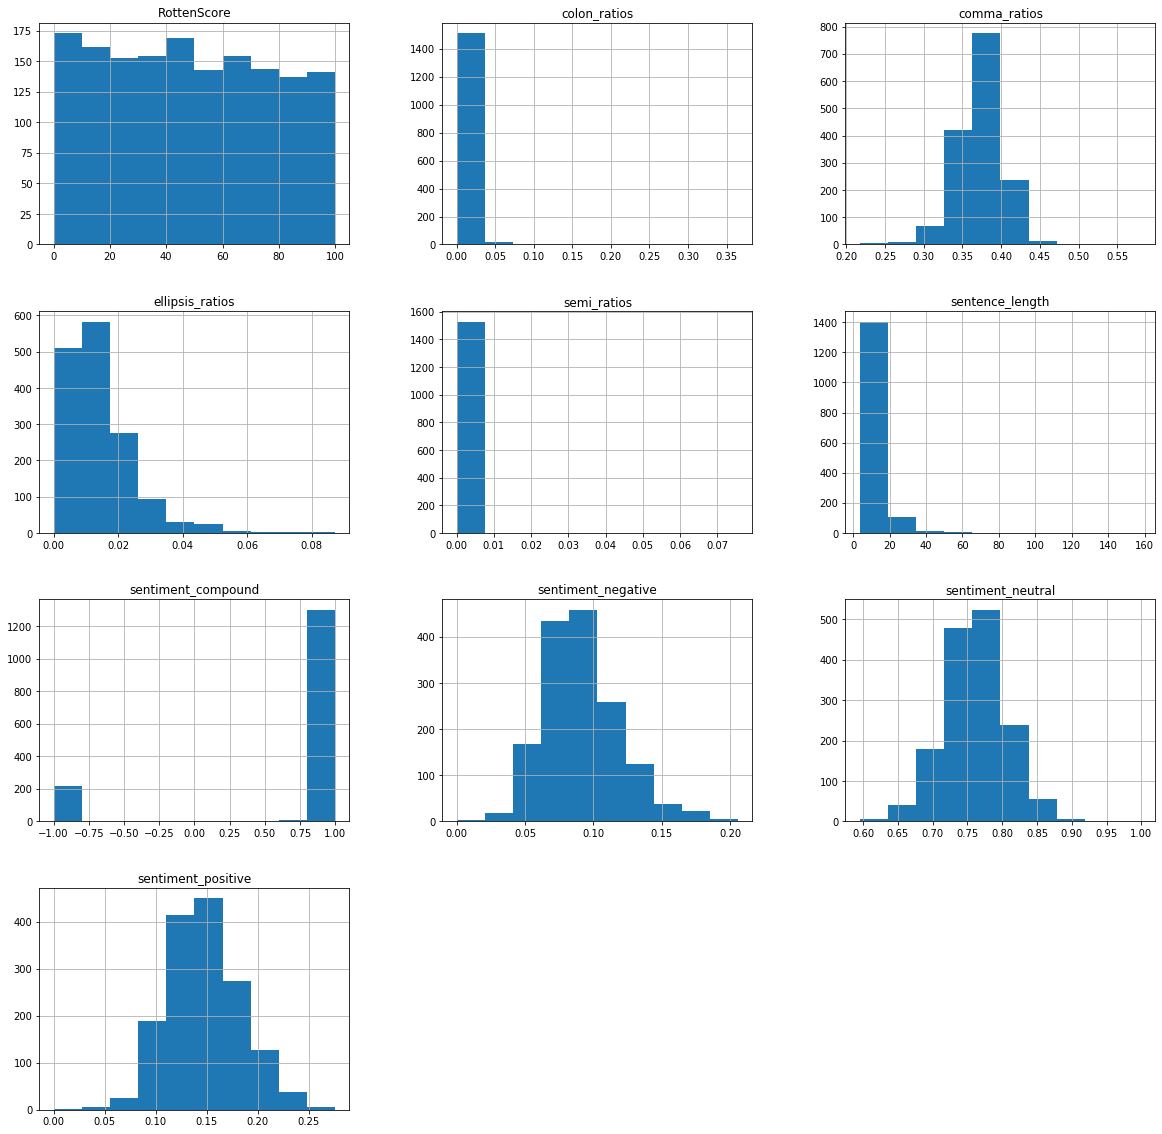

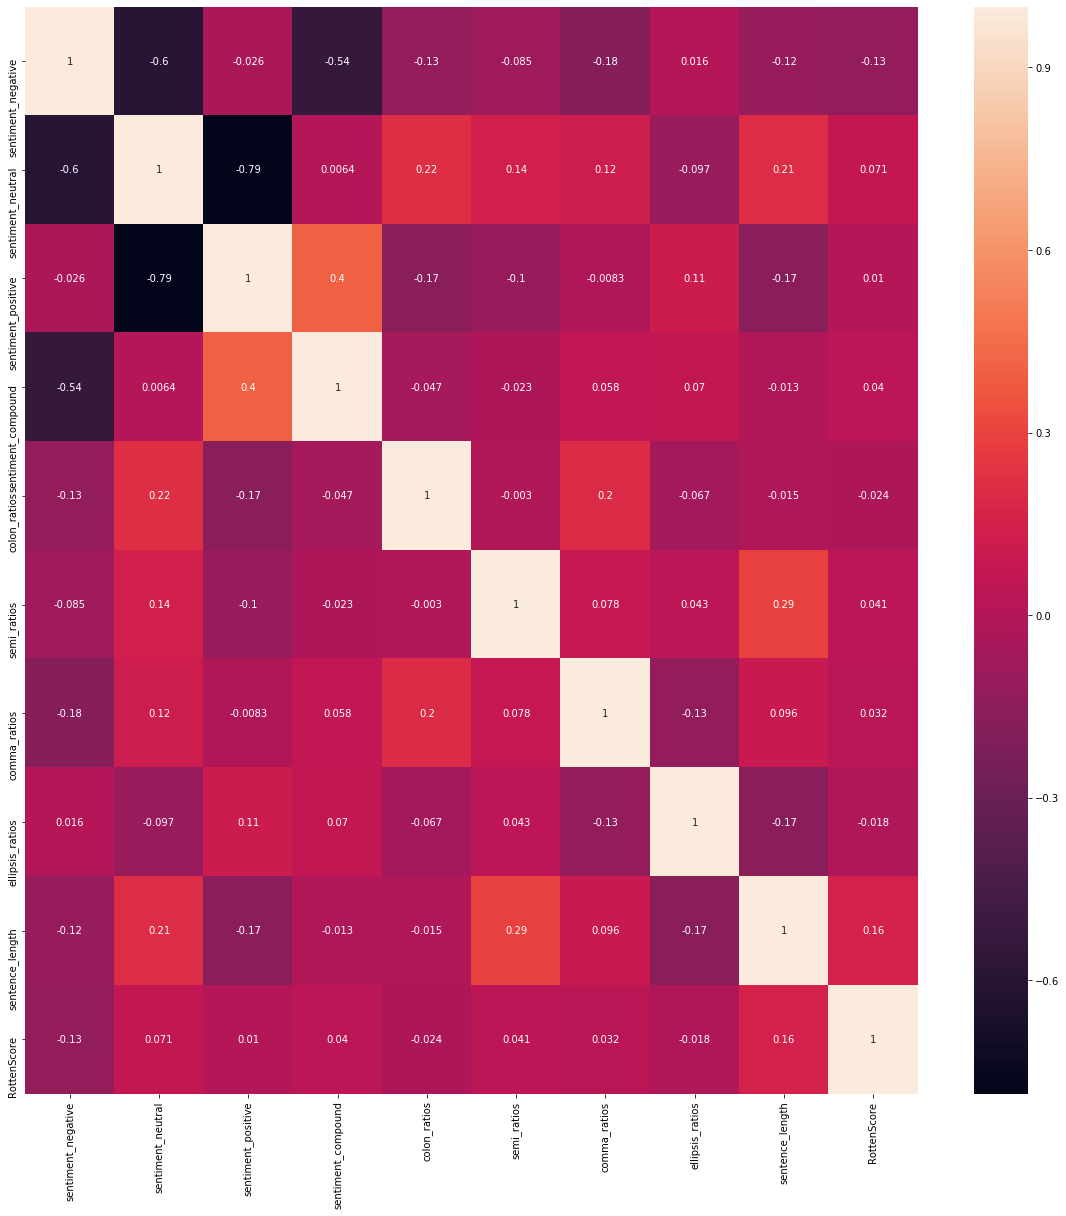

In [74]:
fun.feature_graphics(rotten_df_cut, 
                 col_start='sentiment_negative', 
                 col_end='sentence_length', 
                 scatterdim=(1600,1600), 
                 figsize=(20,20), 
                 browser=False)

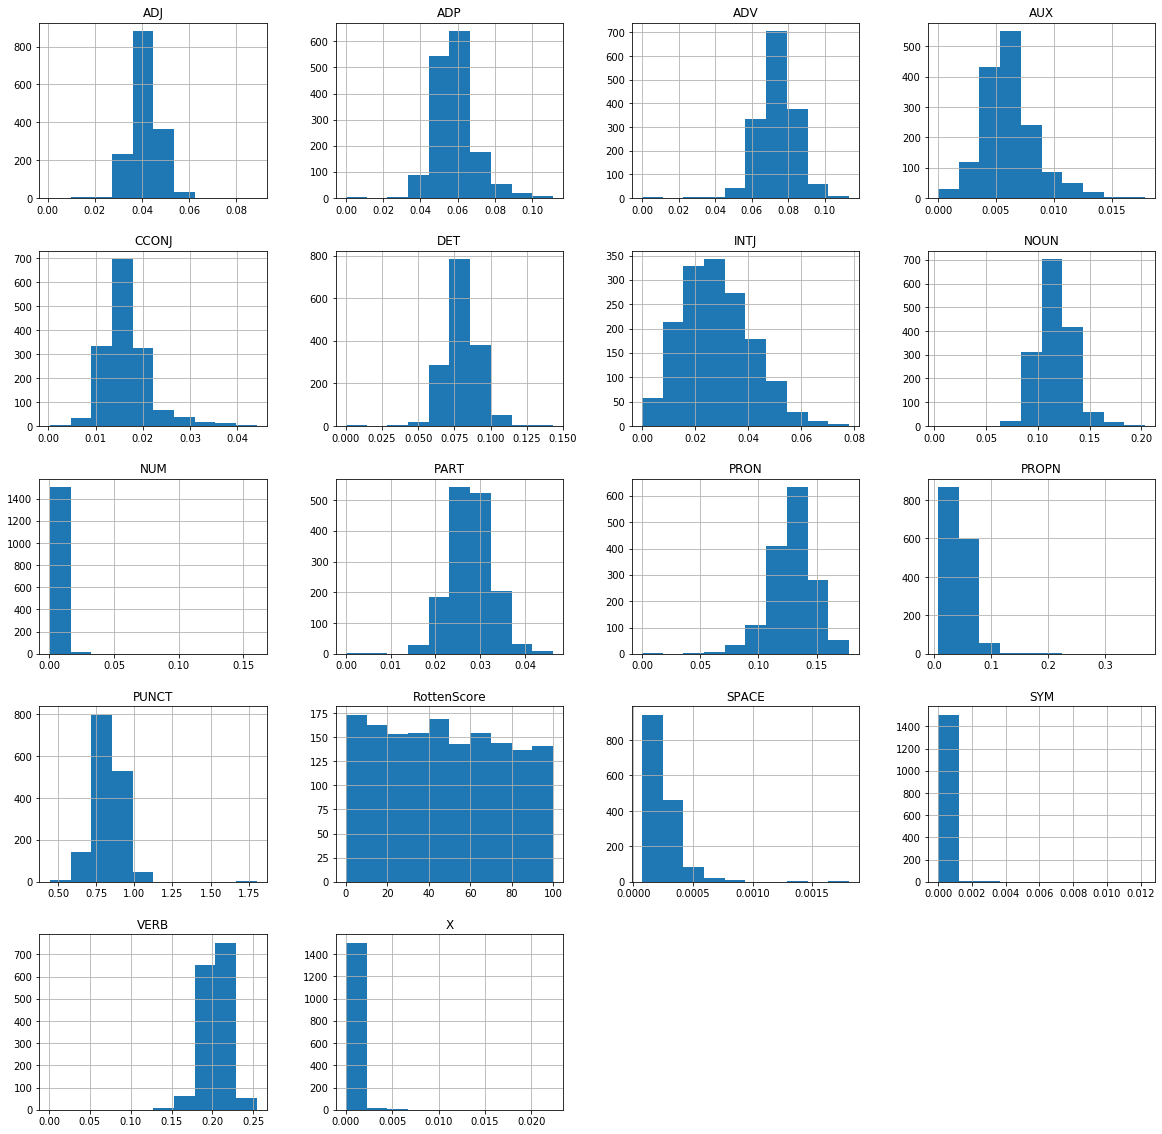

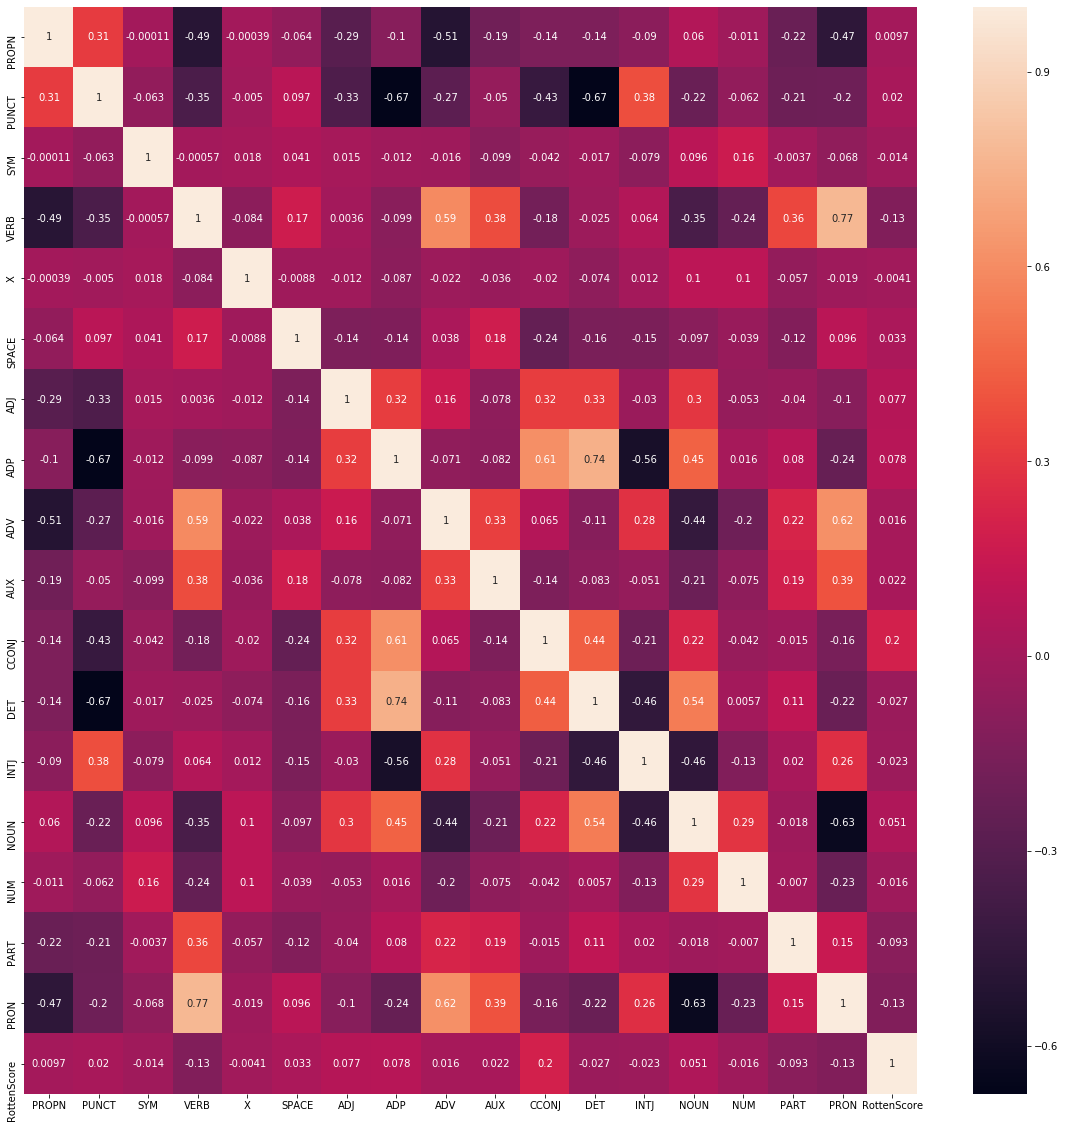

In [76]:
fun.feature_graphics(rotten_df_cut, 
                 col_start='PROPN', 
                 col_end='PRON', 
                 scatterdim=(1600,1600), 
                 figsize=(20,20), 
                 browser=False)

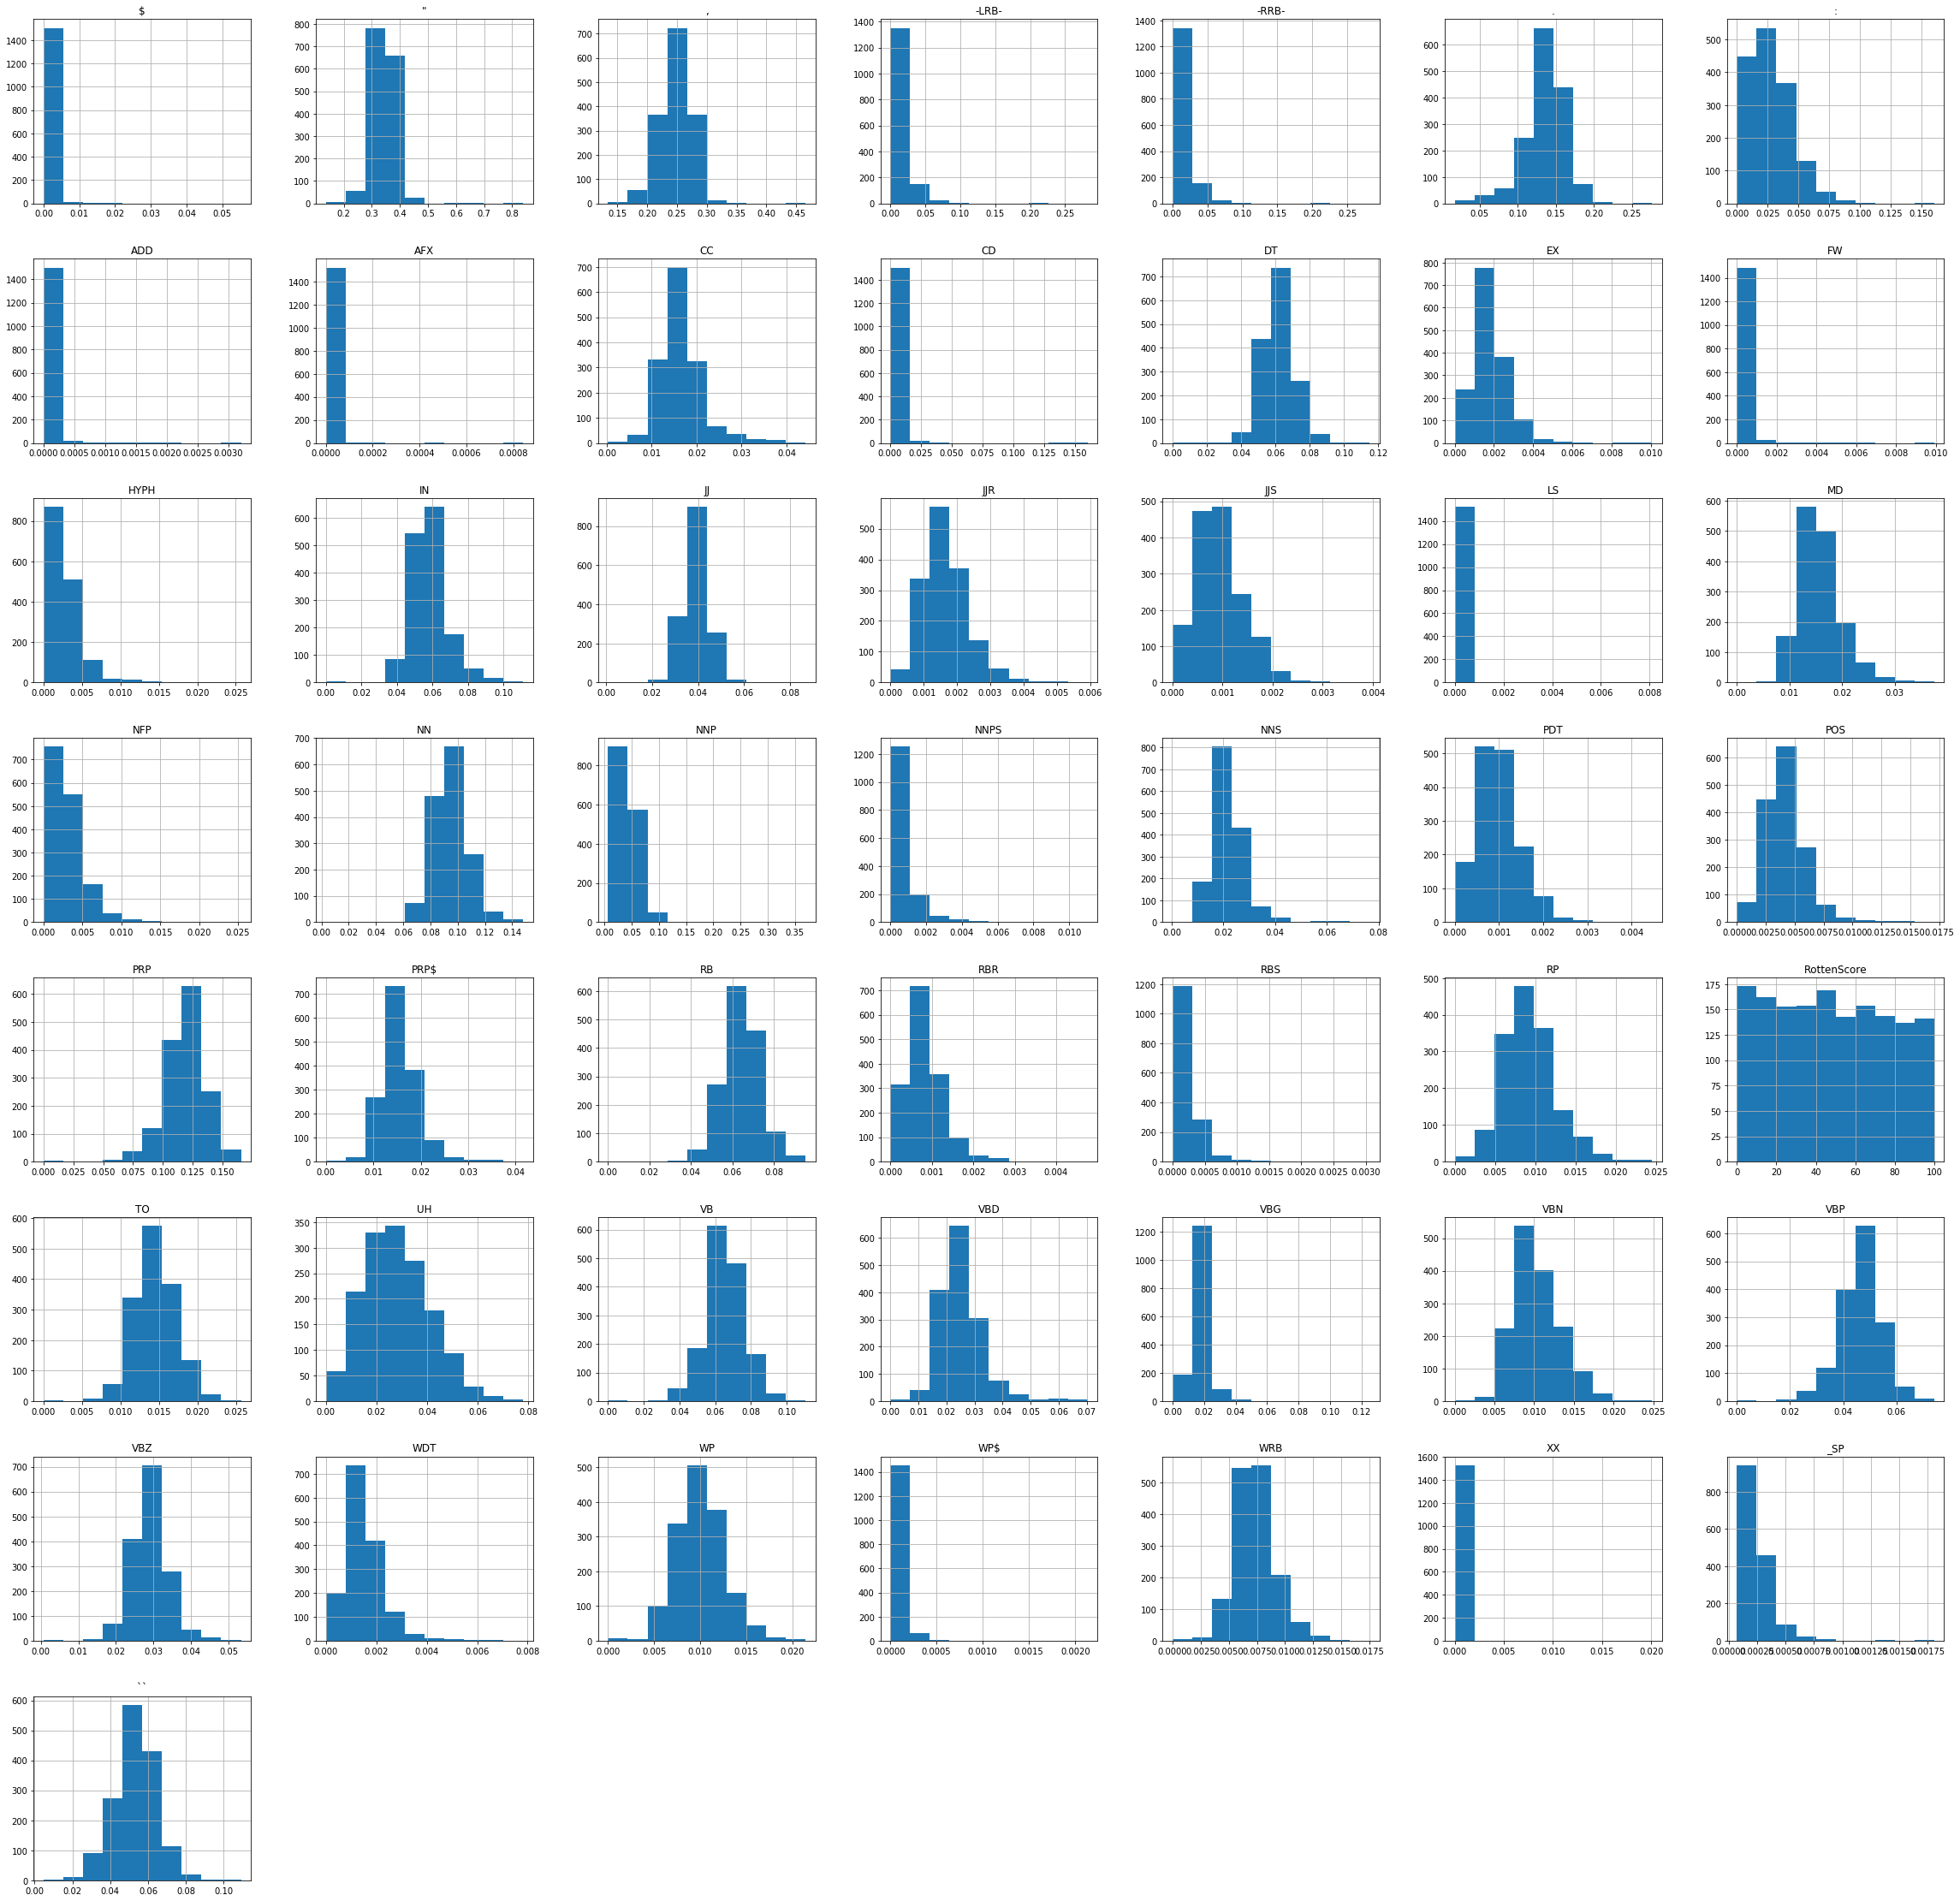

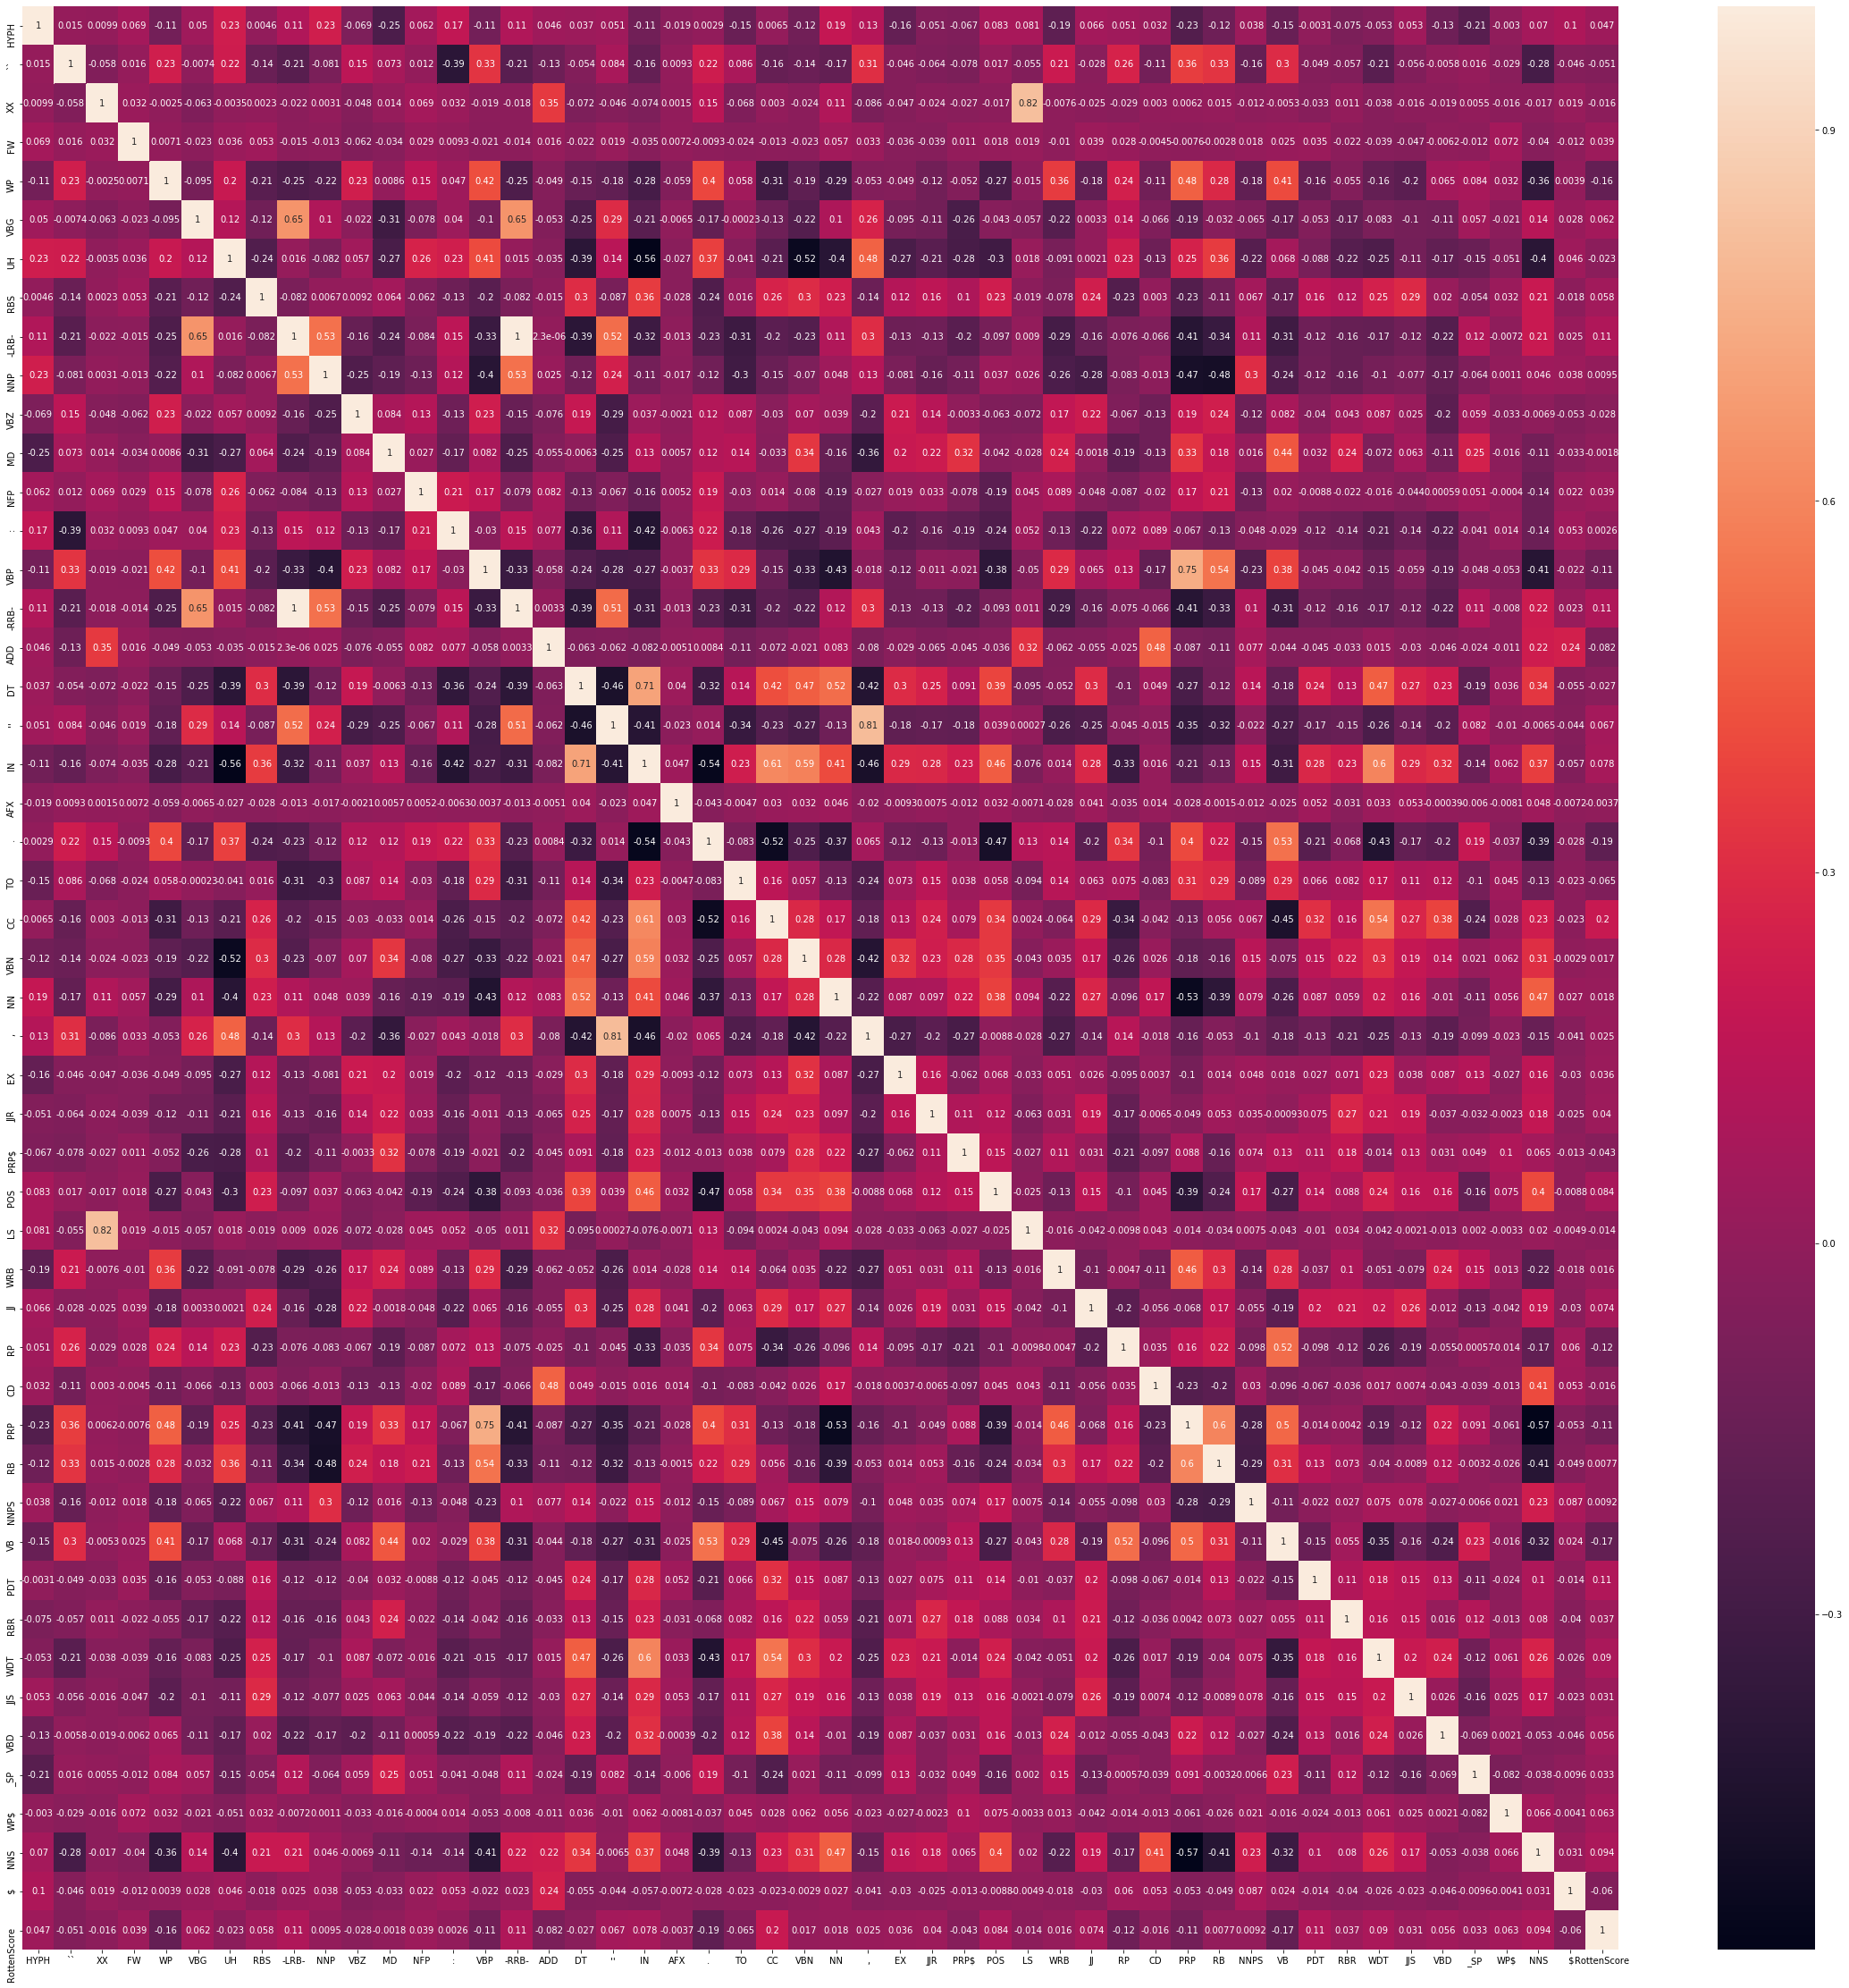

In [80]:
fun.feature_graphics(rotten_df_cut, 
                 col_start='HYPH', 
                 col_end='$', 
                 scatterdim=(3200,3200), 
                 figsize=(40,40), 
                 browser=True)